In [155]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="code."></form>''')

# Introducción

En presente trabajo se analizaron los resultados productivos de una empresa productora de pollos parrilleros para detectar las variables que impactan sobre los resultados y realizar recomendaciones a partir de ello. En segunda instancia se construyó un modelo de regresión 

## Obtención de base de datos

In [ ]:
# Se presentan las librerías utilizadas:
import pandas as pd
import xlsxwriter
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import numpy as np
import datetime
import statsmodels.api as sm
from scipy import stats
import requests
import json
import plotly.express as px
import ydata_profiling
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing


In [ ]:
#Ingresos semanales compilado registra resultados finales de la producción en la pestaña BASE. Contiene además datos de genética, nutrición y sanidad.
df = pd.read_excel(r"C:\Users\ebover\OneDrive - FRIGORIFICO DE AVES SOYCHU S.A.I.C.F.I.A\ingresos semanales compilado.xlsx",sheet_name='BASE', skiprows=1 , usecols=range(1,67))

## Feature extraction preliminar

In [ ]:
df.drop(df[(df['A.D.'] >100)].index, inplace=True) #Se eliminan valores erróneos
df.drop(df[(df['Edad'] >70)].index, inplace=True) #Se elimninan edades fuera de estándar
df.drop(df[(df['Destino'] =='EXP')].index, inplace=True) # se eliminan crianzas de pollos enviados a exportación

In [156]:
#subset para modelo
dfm=df[['granja','Cantid. BB','% a 7 Días','% Mortan.','A.D.','Edad','mes levante','Consumo medio diario (g)','Estación del año','Densidad','Ventilación forzada','Ambiente controlado','localidad', '% desvío consumo std','zona climática','Pes conv 2,7','zona prod' ]]
dfm.head()

,granja,Cantid. BB,% a 7 Días,% Mortan.,A.D.,Edad,mes levante,Consumo medio diario (g),Estación del año,Densidad,Ventilación forzada,Ambiente controlado,localidad,% desvío consumo std,zona climática,"Pes conv 2,7",zona prod
0,357,23200,1.42,10.78,55.29,51.0,1,122.591884,verano,11.047619,N,N,Aldea Asunción,-8.231527,Arrecifes,1.239229,ER
1,605,23176,1.51,10.78,58.43,51.0,1,132.482377,verano,11.885128,N,N,Gualeguay,-0.827811,otra ER,1.240738,ER
2,833,40000,1.45,7.94,57.92,48.0,1,117.309912,verano,10.000000,N,N,Larroque,-7.796369,otra ER,1.352869,ER
3,1710,29000,1.10,8.89,55.49,51.0,1,123.070884,verano,11.600000,N,N,Rocamora,-7.872962,otra ER,1.242188,ER
4,2333,22000,0.92,11.35,55.51,49.0,1,118.916113,verano,11.000000,N,N,Villaguay,-8.107719,otra ER,1.263433,ER


# Encoding

## Transformaciones categóricas

In [ ]:
label_encoder = preprocessing.LabelEncoder()
dfm['Estación del año']= label_encoder.fit_transform(dfm['Estación del año'])
dfm['Estación del año'].unique()


label_encoder = preprocessing.LabelEncoder()
dfm['Ambiente controlado']= label_encoder.fit_transform(dfm['Ambiente controlado'])
dfm['Ambiente controlado'].unique()

label_encoder = preprocessing.LabelEncoder()
dfm['localidad']= label_encoder.fit_transform(dfm['localidad'])
dfm['localidad'].unique()

label_encoder = preprocessing.LabelEncoder()
dfm['zona climática']= label_encoder.fit_transform(dfm['zona climática'])
dfm['zona climática'].unique()

label_encoder = preprocessing.LabelEncoder()
dfm['zona prod']= label_encoder.fit_transform(dfm['zona prod'])
dfm['zona prod'].unique()

label_encoder = preprocessing.LabelEncoder()
dfm['Ventilación forzada']= label_encoder.fit_transform(dfm['Ventilación forzada'])
dfm['Ventilación forzada'].unique()



# Feature selection

## Exploratory Data Analysis


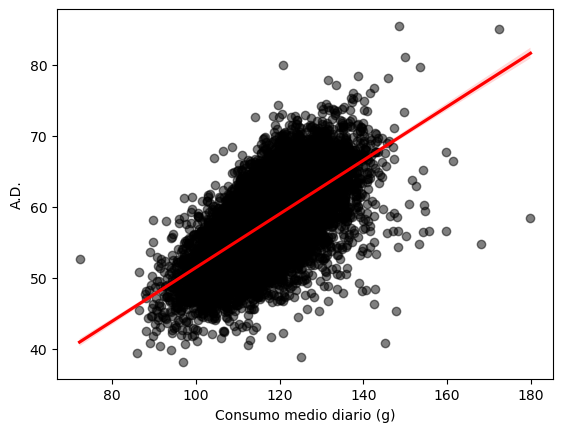

In [157]:
# Gráfico 1
sns.regplot(data=dfm, x = 'Consumo medio diario (g)', y = 'A.D.',
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red"},
            ci = 99);

In [ ]:
np.corrcoef(dfm['Consumo medio diario (g)'], dfm['A.D.'])

Existe una mediana a alta correlación (64%) entre el consumo de alimento y la ganancia de peso, debido a ello se analizará la variable consumo como variable dependiente del modelo a aplicar.

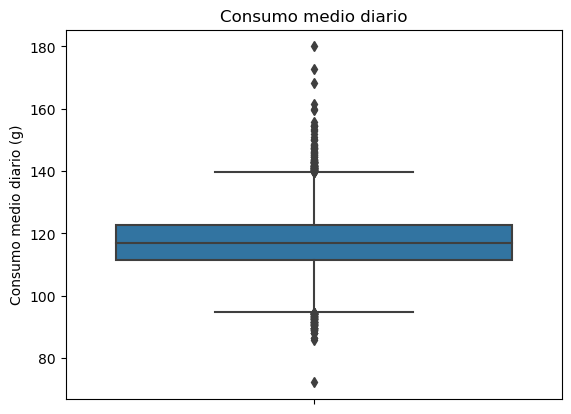

In [158]:
#Gráfico 2
ax=sns.boxplot(data=dfm, y='Consumo medio diario (g)') 
ax.set(title='Consumo medio diario');



Se observa una gran cantidad de valores outliers para la variable consumo por lo se generarán dos subsets para analizarlos por separado: 
dfmwo= Base de datos sin valores outliers
dfmout= Base de datos compuesta únicamente por valores outliers

In [ ]:
dfmo=dfm

In [ ]:
for x in ['Consumo medio diario (g)']:
    q75,q25 = np.percentile(dfmo.loc[:,x],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    dfmo.loc[dfmo[x] < min,x] = np.nan
    dfmo.loc[dfmo[x] > max,x] = np.nan

In [ ]:
dfmwo = dfmo.dropna(axis = 0)

In [ ]:
for x in ['A.D.']:
    q75,q25 = np.percentile(dfmo.loc[:,x],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    dfmo.loc[dfmo[x] < min,x] = np.nan
    dfmo.loc[dfmo[x] > max,x] = np.nan

In [ ]:
dfmwo = dfmo.dropna(axis = 0)

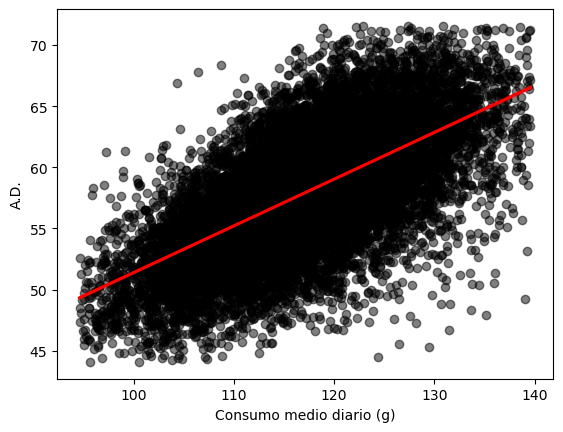

In [159]:
# Gráfico 4
sns.regplot(data=dfmwo, x = 'Consumo medio diario (g)', y = 'A.D.',
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red"},
            ci = 99);

La correlación entre los valores de consumo y ganancia media diaria de peso no se modificó (63.7%) luego de la extracción de los valores outliers de la base de datos.

In [ ]:
np.corrcoef(dfmwo['Consumo medio diario (g)'], dfmwo['A.D.'])

In [ ]:
# se crea un subset conformado por los valores outliers:
dfmout=dfm.loc[(dfm['Consumo medio diario (g)']< 99.2) | (dfm['Consumo medio diario (g)'] >196.05) | (dfm['A.D.'] <47.15) | (df['A.D.'] >68.55)]

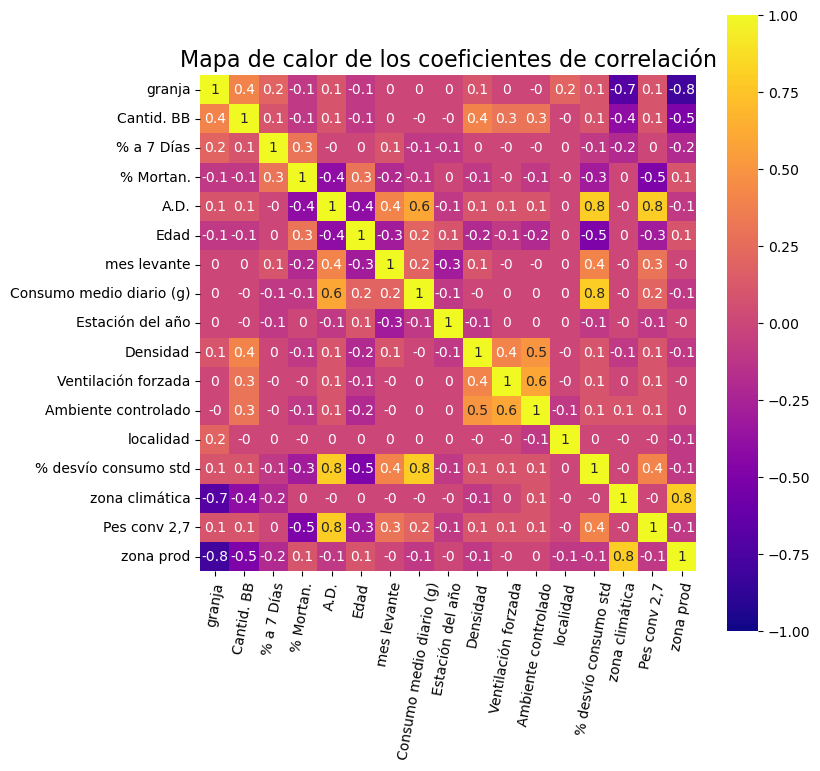

In [160]:
# Gráfico 5
plt.figure(figsize = (8,8))
plt.axis('scaled')
sns.heatmap(dfmwo.corr().round(1), vmin=-1, vmax=1, cmap = "plasma", cbar = True, annot=True)
plt.xticks(rotation = 80)
plt.title('Mapa de calor de los coeficientes de correlación', fontsize = 16);


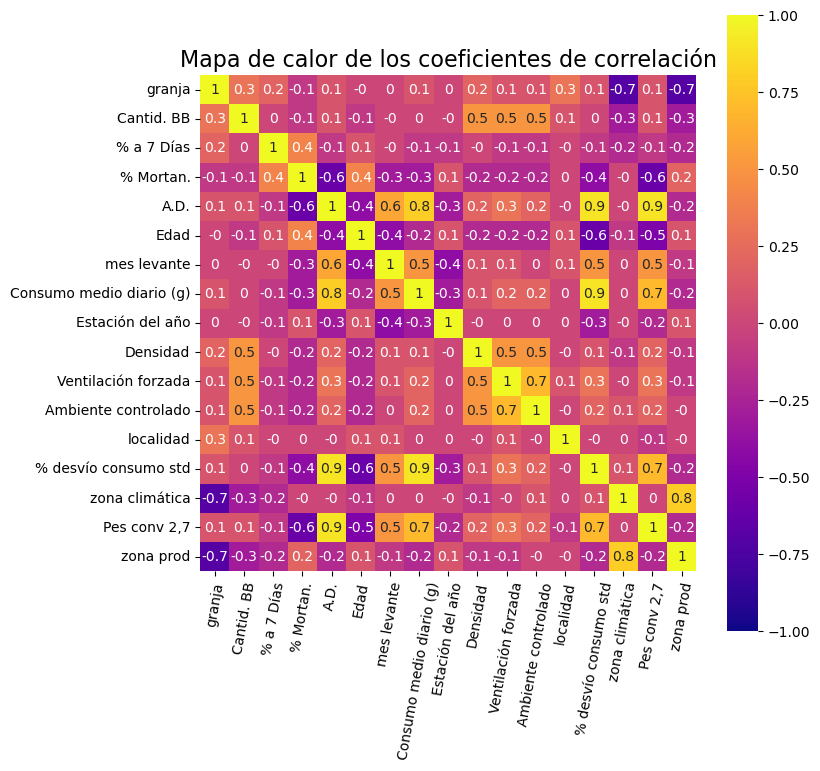

In [161]:
# Gráfico 6
plt.figure(figsize = (8,8))
plt.axis('scaled')
sns.heatmap(dfmout.corr().round(1), vmin=-1, vmax=1, cmap = "plasma", cbar = True, annot=True)
plt.xticks(rotation = 80)
plt.title('Mapa de calor de los coeficientes de correlación', fontsize = 16);

Del análisis de los mapas de calor se desprende que las correlaciones entre el consumo y el resto de las variables analizadas son altas para la ganancia de peso, el desvío del consumo de alimento respecto del estándar (dependiente). Para el caso del grupo de valores outliers tendría además una correlación media a baja con el mes de levante, la estación del año y la mortalidad.

# Entrenamiento modelos machine learning

# RandomForestClassifier

Se confeccionó un modelo de clasificación para predecir la zona climática de producción en función de los valores del resto de las variables de la base.

In [ ]:
# Seleccionar las variables predictoras y la variable de destino
X = dfmwo.drop('zona climática', 1) 
y = dfmwo['zona climática']

In [ ]:
# Dividir el conjunto de datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)

In [ ]:
# Obtener predicciones
y_pred= clf.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred=y_pred, y_true= y_test))

In [ ]:
clf.feature_importances_

In [ ]:
sorted_idx = clf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance");

La precisión promedio alcanzada fue del 86%, lo que indica que el modelo fue capaz de clasificar correctamente la mayoría de las muestras. El modelo mostró una alta precisión para las clases 0, 1 y 3; mientras que la clase 2 tuvo una precisión perfecta, pero una baja recall y f1-score. Esto sugiere que el modelo tuvo dificultades para clasificar correctamente esta clase, ya que su recall fue del 40%.

